# AlphaZero version 8

This AlphaZero version uses the custom and flexible `ValueLayer` to create the value output and the `LineFilterLayer` for the policy output.

* 8 res-blocks
* 128 filters

The model is based on V7, which was trained from scratch on 1.000.000 training examples from the StageThree dataset on a 5x4 board. This model received further training on 2.000.000 StageThree 4x3 samples.

* 1.000.000 @ 5x4 for 16 epochs (from V7)
* 2.000.000 @ 4x3 for 8 epochs


In [1]:
import sys
sys.path.append('..')


import numpy as np
import tensorflow as tf
from tensorflow.python import debug as tf_debug

from keras.callbacks import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.initializers import *
from keras.utils.np_utils import to_categorical
from keras.utils import plot_model
import keras.backend as K
from keras.regularizers import l2
from keras.engine.topology import Layer

from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline
import random
import gc

from LineFilterLayer import LineFilterLayer
from ValueLayer import ValueLayer

baseModelPath = 'model/alphaZeroV7.h5'
modelPath = 'model/alphaZeroV8.h5'

datasetPath = 'StageThree-2000000-4x3-00:15-21_05_2018.npz'

Using TensorFlow backend.


In [2]:
print(K.image_data_format()) 
# expected output: channels_last

channels_last


In [3]:
def dotsAndBoxesToCategorical(inputData):
    inp = np.copy(inputData)
    inp[inp == 255] = 1 # Line - comes first so that target data only has two categories
    inp[inp == 65] = 2 # Box A
    inp[inp == 150] = 3 # Box B
    inp[inp == 215] = 4 # Dot
    cat = to_categorical(inp)
    newShape = inp.shape + (cat.shape[-1],)
    return cat.reshape(newShape)

In [4]:
def imgSizeToBoxes(x):
    return (x-3)/2

def lineFilterMatrixNP(imgWidth,imgHeight):
    boxWidth = imgSizeToBoxes(imgWidth)
    boxHeight = imgSizeToBoxes(imgHeight)
    linesCnt = 2*boxWidth*boxHeight+boxWidth+boxHeight
    mat = np.zeros((imgHeight, imgWidth), dtype=np.bool)
    for idx in range(linesCnt):
        y1 = idx / ((2*boxWidth) + 1)
        if idx % ((2*boxWidth) + 1) < boxWidth:
            # horizontal line
            x1 = idx % ((2*boxWidth) + 1)
            x2 = x1 + 1
            y2 = y1
        else:
            # vertical line
            x1 = idx % ((2*boxWidth) + 1) - boxWidth
            x2 = x1
            y2 = y1 + 1
        px = x2 * 2 + y2 - y1
        py = y2 * 2 + x2 - x1
        mat[py,px] = 1
    return mat


In [5]:
def loadPVDataset(datasetPath):
    rawDataset = np.load(datasetPath)
    
    x_input = rawDataset['input']
    y_policy = rawDataset['policy']
    y_value = rawDataset['value']
    
    x_input = dotsAndBoxesToCategorical(x_input)
    y_policy = y_policy[:,lineFilterMatrixNP(y_policy.shape[-1], y_policy.shape[-2])]
    y_policy /= 255
    
    return (x_input, y_policy, y_value)

np.set_printoptions(precision=2)
(x_input, y_policy, y_value) = loadPVDataset(datasetPath)

In [6]:
print(x_input.shape)
print(y_policy.shape)
print(y_value.shape)
print("input:")
print(x_input[0,::,::,1])
print("policy:")
print(y_policy[0])
print('value:')
print(y_value[0])

(2000000, 9, 11, 5)
(2000000, 31)
(2000000, 1)
input:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
policy:
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
value:
[0.]


In [8]:
width = x_input.shape[-2]
height = x_input.shape[-3]
# LineFilterLayer has to be set before loading the model
LineFilterLayer.imgWidth = width
LineFilterLayer.imgHeight = height
# ValueLayer has to be set before loading the model
ValueLayer.imgWidth = width
ValueLayer.imgHeight = height

model = load_model(baseModelPath,
                   custom_objects={'LineFilterLayer':LineFilterLayer,
                   'ValueLayer':ValueLayer})

model.summary()

LineFilterLayer with image size 11 x 9
ValueLayer with image size 11 x 9
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 5 0                                            
__________________________________________________________________________________________________
input_conv (Conv2D)             (None, None, None, 1 16128       input_1[0][0]                    
__________________________________________________________________________________________________
input_relu (Activation)         (None, None, None, 1 0           input_conv[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 1 512         input_relu[0][0]                 
____________________________________

In [13]:
#sess = K.get_session()
#sess = tf_debug.LocalCLIDebugWrapperSession(sess)
#K.set_session(sess)

# Training
callbacks = []

checkpoint = ModelCheckpoint(filepath=modelPath+".checkpoint", save_weights_only=False)
callbacks.append(checkpoint)

progbar = ProgbarLogger()
callbacks.append(progbar)

tensorboard = TensorBoard(log_dir='model/log2', write_grads=True, write_graph=True, write_images=True, histogram_freq=1)
#callbacks.append(tensorboard)

model.fit(x_input, [y_policy, y_value], epochs=8, batch_size=128, callbacks=callbacks, validation_split=0.001)

model.save(modelPath)

Train on 1998000 samples, validate on 2000 samples
Epoch 1/8
Epoch 1/8
1998000/1998000 [==============================] - 2678s 1ms/step - loss: 1.4474 - policy_loss: 1.2200 - value_loss: 0.1973 - val_loss: 1.4760 - val_policy_loss: 1.2538 - val_value_loss: 0.1946
Epoch 2/8
Epoch 2/8
1998000/1998000 [==============================] - 2682s 1ms/step - loss: 1.4419 - policy_loss: 1.2199 - value_loss: 0.1947 - val_loss: 1.4792 - val_policy_loss: 1.2496 - val_value_loss: 0.2022
Epoch 3/8
Epoch 3/8
1998000/1998000 [==============================] - 2686s 1ms/step - loss: 1.4380 - policy_loss: 1.2193 - value_loss: 0.1914 - val_loss: 1.4637 - val_policy_loss: 1.2480 - val_value_loss: 0.1885
Epoch 4/8
Epoch 4/8
1998000/1998000 [==============================] - 2682s 1ms/step - loss: 1.4366 - policy_loss: 1.2191 - value_loss: 0.1904 - val_loss: 1.4605 - val_policy_loss: 1.2478 - val_value_loss: 0.1858
Epoch 5/8
Epoch 5/8
1998000/1998000 [==============================] - 2682s 1ms/step - loss:

In [14]:
def linesToDotsAndBoxesImage(lines, imgWidth, imgHeight):
    boxWidth = imgSizeToBoxes(imgWidth)
    boxHeight = imgSizeToBoxes(imgHeight)
    linesCnt = 2*boxWidth*boxHeight+boxWidth+boxHeight
    mat = np.zeros((imgHeight, imgWidth), dtype=lines.dtype)
    for idx in range(linesCnt):
        y1 = idx / ((2*boxWidth) + 1)
        if idx % ((2*boxWidth) + 1) < boxWidth:
            # horizontal line
            x1 = idx % ((2*boxWidth) + 1)
            x2 = x1 + 1
            y2 = y1
        else:
            # vertical line
            x1 = idx % ((2*boxWidth) + 1) - boxWidth
            x2 = x1
            y2 = y1 + 1
        px = x2 * 2 + y2 - y1
        py = y2 * 2 + x2 - x1
        mat[py,px] = lines[idx]
    return mat

example: 46766
[[0 0 0 7 0 0 0 6 7 0 0 7 0 0 0 6 0 0 0 7 6 0 7 6 0 7 6 7 7 7 0]]
1.0000001
input (9, 11): 
[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]
prediction policy: 
[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 7 0 0]
 [0 0 0 0 0 0 0 6 0 7 0]
 [0 0 0 0 0 0 7 0 0 0 0]
 [0 0 0 0 0 6 0 0 0 0 0]
 [0 0 0 0 7 0 6 0 0 0 0]
 [0 7 0 6 0 0 0 7 0 6 0]
 [0 0 7 0 7 0 7 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]
prediction value: 
[[0.04]]
target value: 
[0.42]


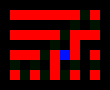

In [16]:
example = random.randrange(x_input.shape[0])
print("example: "+str(example))
imgWidth = x_input.shape[-2]
imgHeight = x_input.shape[-3]

input_data = x_input[example:example+1]

(prediction_lines, prediction_value) = model.predict(input_data)
prediction_lines_print = prediction_lines * 100
print(prediction_lines_print.astype(np.uint8))
print(np.sum(prediction_lines))
prediction = linesToDotsAndBoxesImage(prediction_lines[0], imgWidth, imgHeight)

# print input data
input_data_print = x_input[example,:,:,1] 
input_data_print = input_data_print.astype(np.uint8)
print("input "+str(input_data_print.shape)+": ")
print(input_data_print)

# generate greyscale image data from input data
planes = [1,2,3,4]
input_imgdata = np.sum(x_input[example,:,:,1:], axis=-1) * 255
input_imgdata = input_imgdata.astype(np.uint8)

# print prediction
prediction_data_print = prediction * 100 
prediction_data_print = prediction_data_print.astype(np.uint8)
print("prediction policy: ")
print(prediction_data_print)

print("prediction value: ")
print(prediction_value)

print("target value: ")
print(y_value[example])

# generate greyscale image data from prediction data
prediction_imgdata = prediction * 255
prediction_imgdata = prediction_imgdata.astype(np.uint8)

# generate greyscale image of target data
target_imgdata = linesToDotsAndBoxesImage(y_policy[example], imgWidth, imgHeight) * 255

# merge image data in color channels
merged_imgdata = np.stack([input_imgdata, prediction_imgdata, target_imgdata], axis=2)

#create image
img = Image.fromarray(merged_imgdata, 'RGB')
img = img.resize(size=(img.size[0]*10, img.size[1]*10))

img